<a href="https://colab.research.google.com/github/sotainoue/ProbabilityNext/blob/master/prediction_si.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

import numpy as np
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
from tqdm import tqdm
import pandas as pd

np.set_printoptions(suppress=True,precision=3)

In [2]:
!curl -L -o output.zip https://www.dropbox.com/s/oixt0m25y2c3n2w/output.zip?dl=0
!mkdir data
!unzip output.zip -d data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  1034    0  1034    0     0    643      0 --:--:--  0:00:01 --:--:--  4070
100  145k  100  145k    0     0  72299      0  0:00:02  0:00:02 --:--:-- 72299
Archive:  output.zip
  inflating: data/distance_event_12_order_01.csv  
  inflating: data/distance_event_12_order_02.csv  
  inflating: data/distance_event_12_order_03.csv  
  inflating: data/distance_event_12_order_04.csv  
  inflating: data/distance_event_12_order_05.csv  
  inflating: data/distance_event_12_order_06.csv  
  inflating: data/distance_event_12_order_07.csv  
  inflating: data/distance_event_12_order_08.csv  
  inflating: data/distance_event_12_order_09.csv  
  inflating: data/distance_event_13_order_01.c

In [66]:
#import data of grooming network and nearest neighbor network
!curl -L -o nn_sri.csv  https://www.dropbox.com/s/kd1ew1oyv3ej1i0/nn_sri.csv?dl=0
!curl -L -o grooming.csv  https://www.dropbox.com/s/yn3db8l2q8w1y07/grooming.csv?dl=0

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1211  100  1211    0     0   1171      0  0:00:01  0:00:01 --:--:--  1171
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   707  100   707    0     0    668      0  0:00:01  0:00:01 --:--:--     0


In [52]:
!ls

data  grooming.csv  nn_sri.csv	output.zip  sample_data


In [0]:
nn_file = "nn_sri"  + ".csv"
nn_data = np.genfromtxt(nn_file, delimiter=',')[1:,1:]

grooming_file = "grooming"  + ".csv"
grooming_data = np.genfromtxt(grooming_file, delimiter=',')[1:,1:]

In [0]:
events = []
for file in glob.glob("data/distance*.csv"):
    x = file.split("_")[2]
    if x not in events: 
        events.append(x) 
    
events.sort()


In [69]:
events

['12',
 '13',
 '14',
 '15',
 '22',
 '25',
 '30',
 '31',
 '34',
 '35',
 '36',
 '38',
 '40',
 '46',
 '49',
 '56',
 '59',
 '61']

In [0]:

N = 9 # have to fix this for variable sized groups

X1 = []
X2 = []
Y = []

for e in events:
    
    states = np.zeros(N)
    
    
    for i in range(N):

        dist_file = "data/distance_event_" + e + "_order_0" + str(i+1) + ".csv"
        state_file = "data/state_event_" + e + "_order_0" + str(i+1) + ".csv"

        dist_data = np.genfromtxt(dist_file, delimiter=',')[1:,1:]
        state_data = np.genfromtxt(state_file, delimiter=',')[1:,1]

        dist_data2 = np.zeros((N,N))

        dist_data2[:dist_data.shape[0],:dist_data.shape[1]] = dist_data[:]
        
        j = np.nonzero(states-state_data)[0][0]

        depart = np.zeros(N)
        depart[j] = 1
        X1.append(states.copy())
        X2.append(dist_data2)
        Y.append(depart)
        states[j]=1

    
    
X1 = np.array(X1)
X2 = np.array(X2)
nn= np.array([nn_data])
grooming = np.array([grooming_data])
Y = np.array(Y)


In [0]:
states = tf.convert_to_tensor(X1)
states = tf.expand_dims(states,-1)
dists = tf.convert_to_tensor(X2)
nns = tf.convert_to_tensor(nn)
groomings = tf.convert_to_tensor(grooming)
labels = tf.convert_to_tensor(Y)

##distance model
@tf.function
def calc_distance_loss(in_w1):
    D = in_w1*tf.exp(-dists)

    logits = tf.matmul(D,states) # +in_b - no constant required because the softmax function means someone has to be next
    soft_denom = tf.reduce_sum(tf.where(states==0,tf.exp(logits),0),axis=1)
    soft_denom = tf.expand_dims(soft_denom,-1)
    softmax = tf.where(states==0,tf.exp(logits) / soft_denom ,0)

    softmax = tf.squeeze(softmax)
    cross_entropy = -tf.reduce_sum(labels * tf.math.log(softmax + 1e-10), 1)

    loss = tf.reduce_mean(cross_entropy)
    return loss

## nearest neighbor model
@tf.function
def calc_nn_loss(in_w1):
    N = in_w1*nns

    logits = tf.matmul(N,states) # +in_b - no constant required because the softmax function means someone has to be next
    soft_denom = tf.reduce_sum(tf.where(states==0,tf.exp(logits),0),axis=1)
    soft_denom = tf.expand_dims(soft_denom,-1)
    softmax = tf.where(states==0,tf.exp(logits) / soft_denom ,0)

    softmax = tf.squeeze(softmax)
    cross_entropy = -tf.reduce_sum(labels * tf.math.log(softmax + 1e-10), 1)

    loss = tf.reduce_mean(cross_entropy)
    return loss

##grooming model
@tf.function
def calc_grooming_loss(in_w1):
    G = in_w1*groomings

    logits = tf.matmul(G,states) # +in_b - no constant required because the softmax function means someone has to be next
    soft_denom = tf.reduce_sum(tf.where(states==0,tf.exp(logits),0),axis=1)
    soft_denom = tf.expand_dims(soft_denom,-1)
    softmax = tf.where(states==0,tf.exp(logits) / soft_denom ,0)

    softmax = tf.squeeze(softmax)
    cross_entropy = -tf.reduce_sum(labels * tf.math.log(softmax + 1e-10), 1)

    loss = tf.reduce_mean(cross_entropy)
    return loss

#social + distance model
@tf.function
def calc_loss(in_w1, in_S):
    D = in_w1*tf.exp(-dists)

    S = (in_S)
    logits = tf.matmul(S,states) + tf.matmul(D,states) # +in_b - no constant required because the softmax function means someone has to be next
    soft_denom = tf.reduce_sum(tf.where(states==0,tf.exp(logits),0),axis=1)
    soft_denom = tf.expand_dims(soft_denom,-1)
    softmax = tf.where(states==0,tf.exp(logits) / soft_denom ,0)

    softmax = tf.squeeze(softmax)
    cross_entropy = -tf.reduce_sum(labels * tf.math.log(softmax + 1e-10), 1)

    loss = tf.reduce_mean(cross_entropy)
    return loss

#social + distance + spontenious model
@tf.function
def calc_spo_loss(in_w1, in_S, in_sp):
    D = in_w1*tf.exp(-dists)

    S = (in_S)
    sp = (in_sp)
    logits = tf.matmul(S,states) + tf.matmul(D,states) + tf.matmul(sp,states) # +in_b - no constant required because the softmax function means someone has to be next
    soft_denom = tf.reduce_sum(tf.where(states==0,tf.exp(logits),0),axis=1)
    soft_denom = tf.expand_dims(soft_denom,-1)
    softmax = tf.where(states==0,tf.exp(logits) / soft_denom ,0)

    softmax = tf.squeeze(softmax)
    cross_entropy = -tf.reduce_sum(labels * tf.math.log(softmax + 1e-10), 1)

    loss = tf.reduce_mean(cross_entropy)
    return loss


In [0]:
optimizer = tf.keras.optimizers.Adam(lr=1e-2)

In [0]:
## distance + social model
S1 = tf.Variable(tf.zeros(shape=(N,N ), dtype=tf.float64))
w1 = tf.Variable(tf.random.normal(shape=(1, ), dtype=tf.float64))
#b  = tf.Variable(tf.random.normal(shape=(1,), dtype=tf.float64))

loss_history=[]
weight_history=[]
#b_history=[]
S_history=[]
def train_step():
    with tf.GradientTape() as tape:
    
        loss_value = calc_loss(w1,S1)
        
    
    loss_history.append(loss_value.numpy())
    weight_history.append(w1.numpy())
    S_history.append(S1.numpy())
    #b_history.append(b.numpy())
    grads = tape.gradient(loss_value, [w1,S1])
    optimizer.apply_gradients(zip(grads, [w1,S1]))


In [0]:
## distance + social + spontenious model
S1 = tf.Variable(tf.zeros(shape=(N,N ), dtype=tf.float64))
w1 = tf.Variable(tf.random.normal(shape=(1, ), dtype=tf.float64))
spo1 = tf.Variable(tf.ones(shape=(1,N), dtype=tf.float64))
#b  = tf.Variable(tf.random.normal(shape=(1,), dtype=tf.float64))

loss_history=[]
weight_history=[]
#b_history=[]
S_history=[]
spo_history=[]
def train_step():
    with tf.GradientTape() as tape:
    
        loss_value = calc_spo_loss(w1,S1,spo1)
        
    
    loss_history.append(loss_value.numpy())
    weight_history.append(w1.numpy())
    S_history.append(S1.numpy())
    spo_history.append(spo.numpy())
    #b_history.append(b.numpy())
    grads = tape.gradient(loss_value, [w1,S1,spo1])
    optimizer.apply_gradients(zip(grads, [w1,S1,spo1]))


In [0]:
# distance model
w1 = tf.Variable(tf.random.normal(shape=(1, ), dtype=tf.float64))
#b  = tf.Variable(tf.random.normal(shape=(1,), dtype=tf.float64))

loss_history=[]
weight_history=[]
#b_history=[]
S_history=[]
def train_step():
    with tf.GradientTape() as tape:
    
        loss_value = calc_distance_loss(w1)

    
    loss_history.append(loss_value.numpy())
    weight_history.append(w1.numpy())
    #b_history.append(b.numpy())
    grads = tape.gradient(loss_value, [w1])
    optimizer.apply_gradients(zip(grads, [w1]))


In [0]:
# nn model

w1 = tf.Variable(tf.random.normal(shape=(1, ), dtype=tf.float64))
#b  = tf.Variable(tf.random.normal(shape=(1,), dtype=tf.float64))

loss_history=[]
weight_history=[]
#b_history=[]
S_history=[]
def train_step():
    with tf.GradientTape() as tape:
    
        loss_value = calc_nn_loss(w1)

    
    loss_history.append(loss_value.numpy())
    weight_history.append(w1.numpy())
    #b_history.append(b.numpy())
    grads = tape.gradient(loss_value, [w1])
    optimizer.apply_gradients(zip(grads, [w1]))

In [0]:
# grooming model

w1 = tf.Variable(tf.random.normal(shape=(1, ), dtype=tf.float64))
#b  = tf.Variable(tf.random.normal(shape=(1,), dtype=tf.float64))

loss_history=[]
weight_history=[]
#b_history=[]
S_history=[]
def train_step():
    with tf.GradientTape() as tape:
    
        loss_value = calc_grooming_loss(w1)

    
    loss_history.append(loss_value.numpy())
    weight_history.append(w1.numpy())
    #b_history.append(b.numpy())
    grads = tape.gradient(loss_value, [w1])
    optimizer.apply_gradients(zip(grads, [w1]))

In [98]:
for i in tqdm(range(3000)):
    train_step()

100%|██████████| 3000/3000 [00:10<00:00, 278.63it/s]


1.4171334571431777


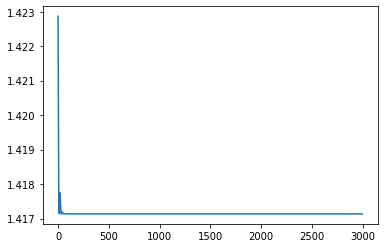

In [99]:
print(loss_history[-1])
plt.plot(loss_history[1:3000])

plt.show()

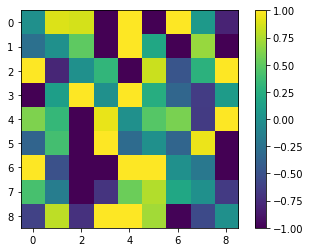

In [31]:
finalS = S_history[-1]
np.fill_diagonal(finalS,0)

plt.imshow(finalS,vmax=1,vmin=-1)
plt.colorbar()
plt.show()


In [42]:
spo_history[-1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

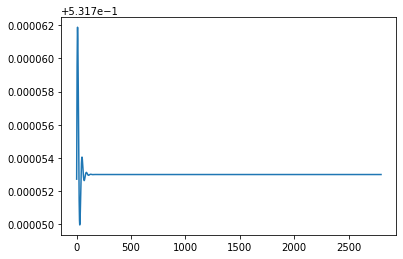

In [100]:
plt.plot(weight_history[200:])

In [92]:
loss_history[-1]

1.414416688019838

In [0]:
S_history[-1]

array([[ 0.   ,  0.73 ,  1.368, -1.768,  1.173, -2.075,  1.619,  0.057,
        -0.629],
       [-0.152,  0.   ,  1.157, -1.922,  2.968, -0.492, -0.906,  0.784,
        -1.646],
       [ 1.17 , -1.184,  0.   ,  0.36 , -3.56 ,  0.409, -0.206,  0.221,
         1.937],
       [-1.963, -0.034,  2.496,  0.   ,  1.141, -0.266,  0.279, -0.757,
         0.319],
       [ 0.67 ,  0.121, -0.924,  0.923,  0.   ,  0.007,  0.854, -0.715,
         1.432],
       [-0.291,  0.231, -0.792,  1.919, -1.162,  0.   , -0.058,  0.945,
        -1.286],
       [ 1.358, -0.524, -0.463, -1.065,  1.195,  0.967,  0.   , -0.202,
        -1.195],
       [ 0.442, -0.195, -0.091, -0.762, -0.204,  0.086,  0.471,  0.   ,
        -0.809],
       [-0.657,  0.544, -0.149,  1.03 ,  0.657,  0.194, -0.605, -0.538,
         0.   ]])

In [0]:
S = S1
for i in range(N):
    np_st = np.zeros((1,N,1))
    np_st[0,i,0]=1
    st = tf.convert_to_tensor(np_st)
    logits = tf.matmul(S,st)
    soft_denom = tf.reduce_sum(tf.where(st==0,tf.exp(logits),0),axis=1)
    soft_denom = tf.expand_dims(soft_denom,-1)
    softmax = tf.where(st==0,tf.exp(logits) / soft_denom ,0)
    print('probability of following horse ' + str(i) + ' : ', softmax.numpy()[0,:,0])

probability of following horse 0 :  [0.    0.067 0.25  0.011 0.152 0.058 0.302 0.121 0.04 ]
probability of following horse 1 :  [0.234 0.    0.034 0.109 0.127 0.142 0.067 0.093 0.194]
probability of following horse 2 :  [0.175 0.141 0.    0.539 0.018 0.02  0.028 0.041 0.038]
probability of following horse 3 :  [0.012 0.01  0.098 0.    0.171 0.464 0.023 0.032 0.191]
probability of following horse 4 :  [0.1   0.604 0.001 0.097 0.    0.01  0.103 0.025 0.06 ]
probability of following horse 5 :  [0.014 0.068 0.168 0.086 0.113 0.    0.294 0.122 0.136]
probability of following horse 6 :  [0.387 0.031 0.062 0.101 0.18  0.072 0.    0.123 0.042]
probability of following horse 7 :  [0.112 0.232 0.132 0.05  0.052 0.273 0.087 0.    0.062]
probability of following horse 8 :  [0.037 0.014 0.487 0.096 0.294 0.019 0.021 0.031 0.   ]


In [0]:
np_st = np.zeros((1,N,1))


In [0]:
print(softmax.numpy()[0,:,0])

[0.    0.067 0.25  0.011 0.152 0.058 0.302 0.121 0.04 ]
